In [1]:
import sys
sys.path.append('/opt/ml/code')

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_modules.transform import get_transform
from my_modules.dataset import TrainDataset, EvalDataset
from my_modules.trainer import Trainer
from my_modules.loss import LabelSmoothing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , ConcatDataset
from torchvision import models

In [2]:
## seeds

random_seed = 42

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
## hyperparameters

model_name = 'efficientnet-b0'
device = 'cuda'
batch_size = 64
lr = 0.00006
num_epoch = 40
target = 'age'
split = 20

df_train_path = 'df/df_labled_train.csv'
df_valid_path = 'df/df_labled_valid.csv'
df_test_path = '/opt/ml/input/data/eval/info.csv'

df_train = pd.read_csv(df_train_path)
df_valid = pd.read_csv(df_valid_path)
df_test = pd.read_csv(df_test_path)

In [4]:
## transform

transform_train = get_transform(augment=True, crop=350, resize=224, cutout=100)
transform_valid = get_transform(augment=False, crop=350, resize=224, cutout=None)

In [5]:
## prepare dataset

train_dataset = TrainDataset(df=df_train, transform=transform_train, target=target)
valid_dataset = TrainDataset(df=df_valid, transform=transform_valid, target=target)

In [6]:
# if using external dataset

df_ff_path = 'df/df_ff.csv'
df_ff = pd.read_csv(df_ff_path)
transform_ff = get_transform(augment=True, crop=400, resize=224, cutout=100)
ff_dataset = TrainDataset(df=df_ff, transform=transform_ff, target=target)

df_mega_path = 'df/df_megaasian_2000.csv'
df_mega = pd.read_csv(df_mega_path)
transform_mega = get_transform(augment=True, crop=224, resize=224, cutout=100)
mega_dataset = TrainDataset(df=df_mega, transform=transform_ff, target=target)

df_train = pd.concat([df_ff, df_mega, df_train])
train_dataset = ConcatDataset([ff_dataset, mega_dataset, train_dataset])

In [6]:
## prepare sampler

from torch.utils.data.sampler import WeightedRandomSampler

weight = df_train[target].value_counts().sort_index().to_numpy()
print('count :', weight)
weight = 1. / weight
samples_weight = np.array([weight[t] for t in df_train[target]])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight)//2)

count : [7175 6874 1071]


In [7]:
## prepare dataloader

dataloaders = {
                'train' : DataLoader(train_dataset, batch_size=batch_size, num_workers=3, drop_last=True, sampler=sampler),
                'valid' : DataLoader(valid_dataset, batch_size=batch_size, num_workers=3, drop_last=False, shuffle=False),
              }

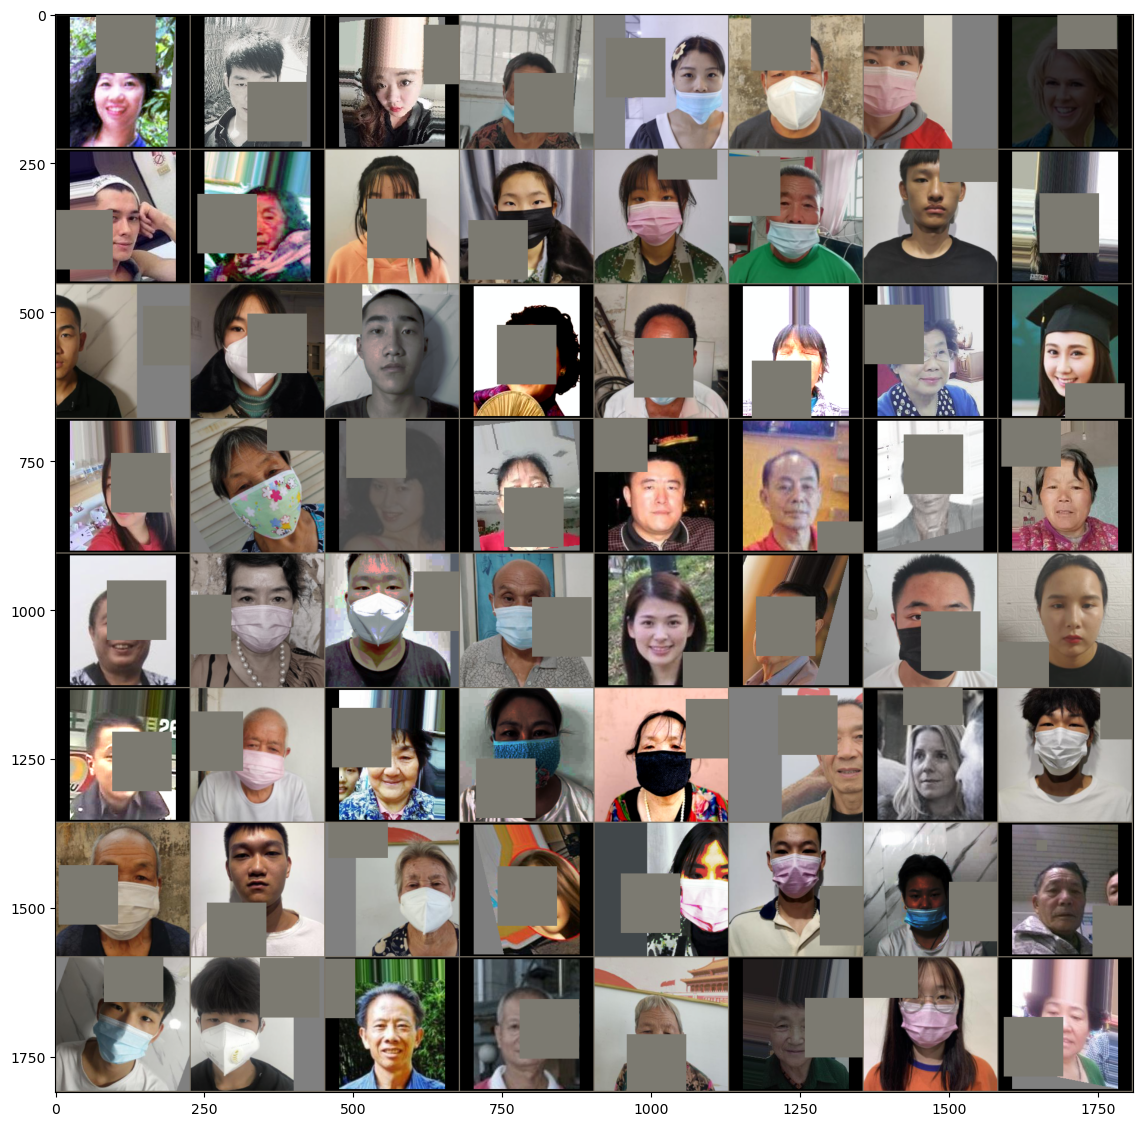

tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0,
        0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 1, 2, 1, 1, 0,
        2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2])


In [11]:
# check input train batch

from my_modules.utils import imshow
batch = next(iter(dataloaders['train']))
imshow(batch[0])
print(batch[1])

In [8]:
## prepare model

if model_name.startswith('efficientnet'):
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained(model_name, num_classes=2 if target=='gender' else 3)
elif model_name.startswith('tf'):
    import timm
    model = timm.create_model('tf_efficientnetv2_b3', pretrained=True, num_classes=2 if target=='gender' else 3)
else:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
    
model.to(device)
print(model_name, 'ready')

efficientnet-b0 ready


In [9]:
criterion = LabelSmoothing(0.05)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = None #optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma = 0.2)

## Train

In [10]:
trainer = Trainer('/opt/ml/code/save')

In [34]:
## resume
# model.load_state_dict(torch.load('/opt/ml/code/save/label/effnet_test018.pt'))

# change lr manually:
for g in optimizer.param_groups:
    g['lr'] = 0.00006

In [11]:
trainer.train(model, dataloaders, criterion, optimizer, device, num_epochs=num_epoch, scheduler=lr_scheduler,
              sub_dir='age', save_name='epoch_')

Epoch 1/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.60it/s]


train Loss: 0.8805 Acc: 0.7313 F1: 0.7303056413328575


100%|██████████| 60/60 [00:07<00:00,  7.67it/s]


valid Loss: 0.6888 Acc: 0.8090 F1: 0.7059093121686005

Epoch 2/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.51it/s]


train Loss: 0.5560 Acc: 0.8444 F1: 0.843204077257813


100%|██████████| 60/60 [00:07<00:00,  7.61it/s]


valid Loss: 0.6165 Acc: 0.8204 F1: 0.7182276956840078

Epoch 3/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.62it/s]


train Loss: 0.4480 Acc: 0.8844 F1: 0.8840992487941812


100%|██████████| 60/60 [00:07<00:00,  7.69it/s]


valid Loss: 0.5778 Acc: 0.8476 F1: 0.7461692430995034

Epoch 4/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.62it/s]


train Loss: 0.3974 Acc: 0.9123 F1: 0.9125568012186182


100%|██████████| 60/60 [00:07<00:00,  7.71it/s]


valid Loss: 0.5549 Acc: 0.8503 F1: 0.7577085783026604

Epoch 5/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.59it/s]


train Loss: 0.3570 Acc: 0.9273 F1: 0.9265981477319915


100%|██████████| 60/60 [00:07<00:00,  7.67it/s]


valid Loss: 0.5283 Acc: 0.8667 F1: 0.7705069150482388

Epoch 6/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.52it/s]


train Loss: 0.3221 Acc: 0.9473 F1: 0.9471954472567788


100%|██████████| 60/60 [00:07<00:00,  7.64it/s]


valid Loss: 0.5163 Acc: 0.8672 F1: 0.7682878587170245

Epoch 7/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.61it/s]


train Loss: 0.3136 Acc: 0.9473 F1: 0.9476269359252809


100%|██████████| 60/60 [00:07<00:00,  7.70it/s]


valid Loss: 0.5140 Acc: 0.8680 F1: 0.7650865996188836

Epoch 8/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.59it/s]


train Loss: 0.2912 Acc: 0.9600 F1: 0.9596507625993733


100%|██████████| 60/60 [00:07<00:00,  7.59it/s]


valid Loss: 0.5010 Acc: 0.8778 F1: 0.7729858375201107

Epoch 9/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.57it/s]


train Loss: 0.2858 Acc: 0.9587 F1: 0.9585081496427797


100%|██████████| 60/60 [00:07<00:00,  7.73it/s]


valid Loss: 0.4936 Acc: 0.8788 F1: 0.7744216990932227

Epoch 10/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.57it/s]


train Loss: 0.2737 Acc: 0.9670 F1: 0.9669838138505616


100%|██████████| 60/60 [00:07<00:00,  7.65it/s]


valid Loss: 0.5018 Acc: 0.8775 F1: 0.7786435961053669

Epoch 11/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.60it/s]


train Loss: 0.2728 Acc: 0.9673 F1: 0.967201508129634


100%|██████████| 60/60 [00:07<00:00,  7.69it/s]


valid Loss: 0.4918 Acc: 0.8810 F1: 0.7721688169553628

Epoch 12/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.60it/s]


train Loss: 0.2605 Acc: 0.9717 F1: 0.9717106809834178


100%|██████████| 60/60 [00:07<00:00,  7.66it/s]


valid Loss: 0.4739 Acc: 0.8849 F1: 0.7738653960690888

Epoch 13/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.59it/s]


train Loss: 0.2528 Acc: 0.9771 F1: 0.977140893279944


100%|██████████| 60/60 [00:07<00:00,  7.73it/s]


valid Loss: 0.4668 Acc: 0.8868 F1: 0.7808940069925271

Epoch 14/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.56it/s]


train Loss: 0.2426 Acc: 0.9805 F1: 0.980441417769406


100%|██████████| 60/60 [00:07<00:00,  7.68it/s]


valid Loss: 0.4683 Acc: 0.8868 F1: 0.7814044958596299

Epoch 15/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.65it/s]


train Loss: 0.2454 Acc: 0.9784 F1: 0.9784516179313737


100%|██████████| 60/60 [00:07<00:00,  7.68it/s]


valid Loss: 0.4782 Acc: 0.8886 F1: 0.7845917258987649

Epoch 16/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.54it/s]


train Loss: 0.2365 Acc: 0.9828 F1: 0.9828069259581843


100%|██████████| 60/60 [00:07<00:00,  7.68it/s]


valid Loss: 0.4621 Acc: 0.8889 F1: 0.7799225680682881

Epoch 17/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.60it/s]


train Loss: 0.2341 Acc: 0.9837 F1: 0.9836010462610979


100%|██████████| 60/60 [00:07<00:00,  7.66it/s]


valid Loss: 0.4576 Acc: 0.8889 F1: 0.7709020574626627

Epoch 18/40
----------


100%|██████████| 118/118 [00:32<00:00,  3.64it/s]


train Loss: 0.2342 Acc: 0.9811 F1: 0.9809793851550301


100%|██████████| 60/60 [00:07<00:00,  7.65it/s]


valid Loss: 0.4595 Acc: 0.8884 F1: 0.7812193743735718

Epoch 19/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.49it/s]


train Loss: 0.2248 Acc: 0.9866 F1: 0.9865312180753723


100%|██████████| 60/60 [00:07<00:00,  7.59it/s]


valid Loss: 0.4622 Acc: 0.8844 F1: 0.7714635210312649

Epoch 20/40
----------


100%|██████████| 118/118 [00:34<00:00,  3.43it/s]


train Loss: 0.2254 Acc: 0.9876 F1: 0.9874909060983867


100%|██████████| 60/60 [00:07<00:00,  7.63it/s]


valid Loss: 0.4515 Acc: 0.8905 F1: 0.7817304926531525

Epoch 21/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.50it/s]


train Loss: 0.2272 Acc: 0.9837 F1: 0.983657751462205


100%|██████████| 60/60 [00:07<00:00,  7.54it/s]


valid Loss: 0.4519 Acc: 0.8910 F1: 0.7857153985887643

Epoch 22/40
----------


100%|██████████| 118/118 [00:33<00:00,  3.57it/s]


train Loss: 0.2215 Acc: 0.9869 F1: 0.9868604645019649


 20%|██        | 12/60 [00:01<00:07,  6.55it/s]


KeyboardInterrupt: 

## Logs

기본 설정

```
model_name = 'efficientnet-b0'
batch_size = 64
lr = 0.00006
split = 20
transform_train = get_transform(augment=True, crop=350, resize=224, cutout=100)
transform_valid = get_transform(augment=False, crop=350, resize=224, cutout=None)
```

## Age Log

1. tf_eff b3 + ff:  
    - epoch23)  
      - train Loss: 0.2512 Acc: 0.9638 F1: 0.963731509280305
      - valid Loss: 0.4652 Acc: 0.9042 F1: 0.7983025945957932

2. tf_eff b3 + mega:  
    - epoch14)  
      - train Loss: 0.2475 Acc: 0.9683 F1: 0.9683685312363205
      - valid Loss: 0.4115 Acc: 0.9106 F1: 0.8063435215039828

## Gender Experiment Logs

2. tf effb3 0.0003->0.00006
   epoch 17)
      - train Loss: 0.1367 Acc: 0.9912 F1: 0.9911960535284283
      - valid Loss: 0.1314 Acc: 0.9944 F1: 0.9941665702144545

2. ff, AdamW(wd=0.0001) lr 0.00006 --> 0.00001
   epoch ?)
      - train Loss: 0.1550 Acc: 0.9821 F1: 0.9821238701547585
      - valid Loss: 0.1367 Acc: 0.9913 F1: 0.9908242378118639

valid Loss: 0.1367 Acc: 0.9913 F1: 0.9908242378118639
    


## Mask Experiment Logs

---

1. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 21)
      - train Loss: 0.2192 Acc: 0.9767 F1: 0.9766713917541754
      - valid Loss: 0.1739 Acc: 0.9989 F1: 0.9985207090460696
        

## Age & Gender Experiment Logs

---

### loss function test

---

1. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=CE, WeightedSampler, split 25%, optimizer=Adam
   * epoch 18)
     - train Loss: 0.0991 Acc: 0.9655 F1: 0.9654261306812848
     - valid Loss: 0.0980 Acc: 0.9778 F1: 0.9772288369633227  
  * before first patience

---

2. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=LS(0.05), WeightedSampler, split 25%, optimizer=Adam
    * epoch 21)
     - train Loss: 0.3310 Acc: 0.9638 F1: 0.963728513759618
     - valid Loss: 0.3071 Acc: 0.9786 F1: 0.9791634664746235 

---

3. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=F1_Loss, split 25%, optimizer=Adam
   * epoch 13)
     - train Loss: 0.0710 Acc: 0.9584 F1: 0.9476713834498373
     - valid Loss: 0.0403 Acc: 0.9765 F1: 0.9748789208889367
   * epoch 3)
     - train Loss: 0.0594 Acc: 0.9655 F1: 0.9555452013464937
     - valid Loss: 0.0369 Acc: 0.9782 F1: 0.9776768545260203

---

### split ratio test

---

4. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 15%
    * epoch 21)
      - train Loss: 0.3381 Acc: 0.9597 F1: 0.9597144587078792
      - valid Loss: 0.2948 Acc: 0.9852 F1: 0.982564296238198
      
---

5. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 27)
      - train Loss: 0.3211 Acc: 0.9668 F1: 0.9668728849468181
      - valid Loss: 0.2878 Acc: 0.9854 F1: 0.9842203787970396
      
---

6. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 25%
    * epoch 22)
      - train Loss: 0.3321 Acc: 0.9639 F1: 0.9638739223128628
      - valid Loss: 0.2910 Acc: 0.9829 F1: 0.9792575649184908
      
---

7. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 30%
    * epoch 29)
      - train Loss: 0.3171 Acc: 0.9686 F1: 0.9685813478405522
      - valid Loss: 0.3047 Acc: 0.9772 F1: 0.9764751322879572

## Debug

In [11]:
model.load_state_dict(torch.load('/opt/ml/code/save/gender/best_20_log2.pt'))
model.eval()
print('ready')

ready


In [12]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

model.eval()
y_true = []
y_pred = []
wrong = []
for inputs, labels in dataloaders['valid']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        
        for p, t, inp in zip(preds, labels, inputs):
            if p.item() != t.item():
                wrong.append((inp.cpu().numpy(), p.item(), t.item()))

mtx = confusion_matrix(y_true, y_pred)
print(mtx)


[[1446   24]
 [  21 2289]]


In [ ]:
d = {y_true:y_true, 'y_pred'

with open('pred.pkl', 'wb') as f:
    pickle.dump(list, f)

In [ ]:
label_ = list(range(6))

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(mtx, cmap='Blues', vmax=100, vmin=-20)

ax.set_xticks(np.arange(len(label_)))
ax.set_yticks(np.arange(len(label_)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_)
ax.set_yticklabels(label_)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(label_)):
    for j in range(len(label_)):
        if mtx[i, j]:
            text = ax.text(j, i, mtx[i, j],
                           ha="center", va="center", color="w", size=10)
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')
ax.set_title("Confusion mtx")
fig.tight_layout()
plt.show()

In [ ]:
iterator = iter(wrong)

label = ["Male with mask", "Female with Mask", "Male incorrect mask", "Female no mask", "Male incorrect mask", "Female no mask"]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax in axes.flatten():
    img, p, t = next(iterator)
    img = img.transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f't : {label[t]}\np : {label[p]}')
plt.show()